In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import xgboost as xgb

In [2]:
datasig=pd.read_csv("sig_many_values.csv")
databkg=pd.read_csv("bkg_many_values.csv")
datasig["label"]=1
databkg["label"]=0
data2=datasig.append(databkg,ignore_index=True)

In [3]:
data2.shape

(151762, 58)

In [4]:
X,Y=data2.iloc[:,:-2],data2.iloc[:,-1]
weights=data2.iloc[:,-2]
X_train, X_test, y_train, y_test,weight_train,weight_test= train_test_split(X, Y,weights,test_size=0.4, random_state=7)

In [5]:
weight_train=weight_train*10**4
weight_test=weight_test*10**4
import numpy as np
weight_train=np.asarray(weight_train)
weight_test=np.asarray(weight_test)
y_test=np.asarray(y_test)
y_train=np.asarray(y_train)
dtest = xgb.DMatrix(data=X_test,weight=weight_test)

In [6]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=weight_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.76%


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

AUC: 0.705


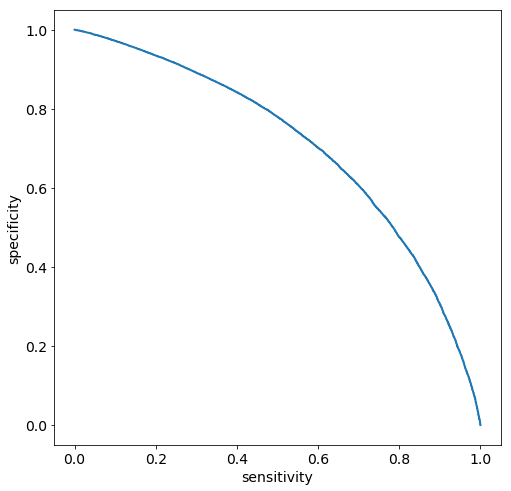

In [8]:
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs,sample_weight=weight_test)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs,sample_weight=weight_test)
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot(tpr, 1-fpr,linewidth=2)
# show the plot
plt.xlabel("sensitivity",fontsize=14)
plt.ylabel("specificity",fontsize=14)
plt.tick_params(axis="both",labelsize=14)
plt.show()

In [10]:
filename="xgboost_weight.CSV"
with open(filename,"w") as file:
    for kk in range(tpr.size):
        file.write(str(fpr[kk]))
        file.write(" ")
        file.write(str(tpr[kk]))
        file.write("\n")

In [12]:
fpr.size

60520

In [13]:
tpr.size

60520